This notebook documents my attempt to tackle the Titanic data set. I have spent some time reading and learning from others kernels and discussions at Kaggle. Hence most of the ideas here is not fully original and I don't claim I've invented the methods presented here. The purpose of this notebook is to map what I found most useful and interesting, and to record some useful tricks (mostly pandas and sklearn).

Some kernels I've found particularly useful (there are many others):
- Li-Yen Hsu: Titanic - Neural Network https://www.kaggle.com/liyenhsu/titanic-neural-network
- Niklas Donges: End to End Project with Python https://www.kaggle.com/niklasdonges/end-to-end-project-with-python

In [2]:
import pandas as pd
import numpy as np
import random as rnd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# read data
train_raw = pd.read_csv("input/train.csv")
test_raw = pd.read_csv("input/test.csv")

### Basic data overview

In [4]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(train_raw.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
train_raw.describe(include = "all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Carter, Mr. William Ernest",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [7]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
test_raw.describe(include = "all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Stokes, Mr. Philip Joseph",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [9]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Missing values need to be fixed. **Ticket** has large number of duplicates in both train and test set. I will explore this a further below.

### Missing values

In [10]:
# missing values in train
train_raw.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
# missing values in test
test_raw.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We observe that:
-  in the **training set**, some values of *Age*, *Cabin*, and *Embarked* are missing
-  in the **test set**, some values of *Age*, *Fare*, and *Cabin* are missing
-  for **Cabin**, more than half of values is missing in each set and therefore I will remove this feature. This might be something to work on in future -- explore the *Cabin* feature more in detail instead just dropping it.
-  the rest of the missing values will be populated with estimates derived from the valid data

**Working copies of the datasets**:
Before removing and modifying features, I will make copies of the origianl datasets

In [12]:
# deep copy to copy data and indeces
train = train_raw.copy(deep=True)
test = test_raw.copy(deep=True)

# dropping Passenger's IDs and Cabin
train = train.drop(['PassengerId', 'Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

For the missing values of **Age**, I'll deal with those below, where I'll bin the age data and estimate the missing values from the other data. For now, let's set the NaN age to -1.

In [13]:
train['Age'] = train['Age'].fillna(-1)
test['Age'] = test['Age'].fillna(-1)

Two values are missing in the **Embarked** column of the train set. 

In [14]:
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


Let's have a look on the distribution of possible values of Embarked in the combined dataset.

In [15]:
(pd.concat([train,test])).groupby('Embarked').count()['Sex']

Embarked
C    270
Q    123
S    914
Name: Sex, dtype: int64

Embarking in Southampton is by far the most common one and I will populate the missing values in the train set by 'S'.

In [16]:
train['Embarked'] = train['Embarked'].fillna('S')

One value is missing in the **Fare** column of the test set.

In [17]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


Let's have a look if Fare is correlated with any other feature.

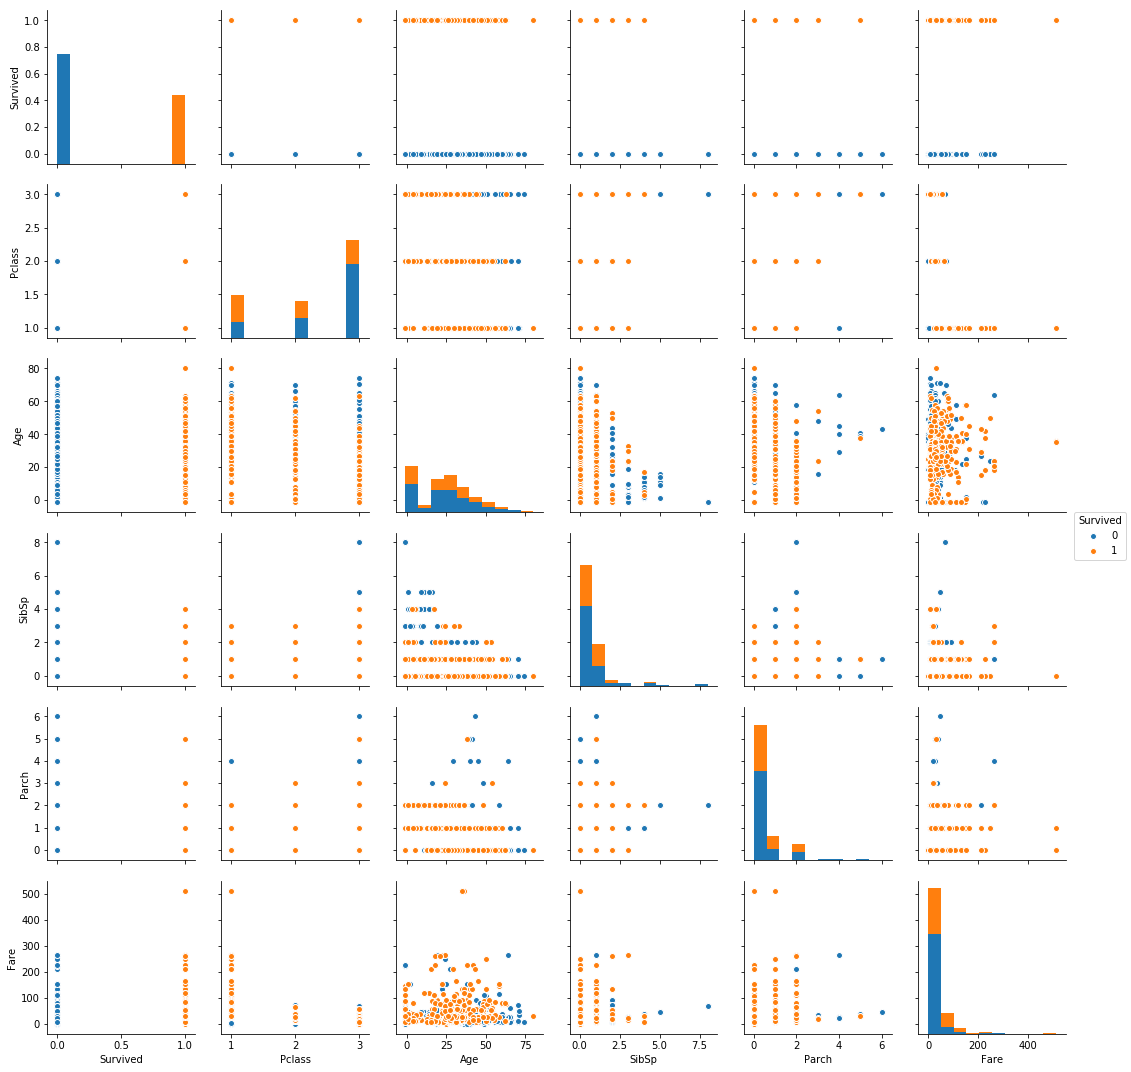

In [18]:
sns.pairplot(train, hue="Survived", dropna=True)

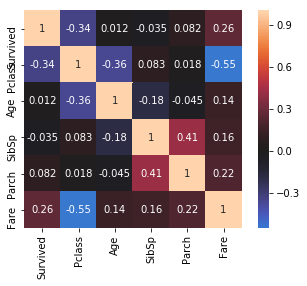

In [19]:
corr = train.corr()
sns.heatmap(corr, square=True, annot=True, center=0)

*Pclass* is strongly correlated with *Fare* -- the lower the class, the lower is the fare. Let's populate the single NaN *Fare* in the test set by the mean *Fare* for its *Pclass* of 3.

In [20]:
mean_fare_3 = np.nanmean(pd.concat([train[train['Pclass']==3]['Fare'],test[test['Pclass']==3]['Fare']]).values)
print("Mean Fare of passengers with Pclass==3:", mean_fare_3)
test['Fare'] = test['Fare'].fillna(mean_fare_3)

Mean Fare of passengers with Pclass==3: 13.3028887006


There are still missing values for *Age* and we will deal with those below.

In [21]:
train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [22]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### Feature engineering
**Ticket** -- Above analysis showed that more than half of the values in Ticket are duplicated. Let's have a closer look on the examples.

In [23]:
train["Ticket"][:20]

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

Duplicated examples together:

In [24]:
pd.concat(g for _, g in train.groupby("Ticket") if len(g) > 1)[:20]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
257,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,S
504,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,S
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,S
262,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,S
558,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,S
585,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,S
110,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,S
475,0,1,"Clifford, Mr. George Quincy",male,-1.0,0,0,110465,52.0000,S
329,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,C
523,1,1,"Hippach, Mrs. Louis Albert (Ida Sophia Fischer)",female,44.0,0,1,111361,57.9792,C


It seems that the same Ticket is associated with people traveling together -- they often have same names (married couple, family) and same cabin. Is this correlated with survival?

In [25]:
train['Alone'] = 1
train.loc[train.duplicated(subset='Ticket'),'Alone'] = 0

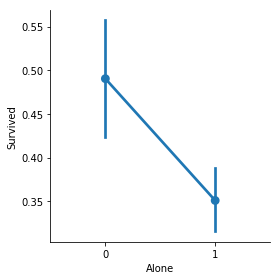

In [26]:
sns.factorplot(x="Alone", y="Survived", data=train)

It looks like the new feature **Alone** is correlated with the survival. So I will keep it and I will drop the feature Ticket now.

In [27]:
test['Alone'] = 1
test.loc[test.duplicated(subset='Ticket'),'Alone'] = 0

I'll drop the *Ticket* feature for now. There are probably ways to use it further though (e.g. exploring the first letters) -- something to try in future.

In [28]:
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

**Name** -- The feature does not bring much insight as it is. A popular (and logical) method among Kaggle kernels is to extract the title of each person from their names. The title corresponds to social and economic status and might be correlated with survival.

In [29]:
# the following is adopted from 
# https://www.kaggle.com/niklasdonges/end-to-end-project-with-python

data = [train, test]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [30]:
pd.concat([train,test]).groupby('Title').count()['Sex']

Title
Master     61
Miss      264
Mr        757
Mrs       198
Rare       29
Name: Sex, dtype: int64

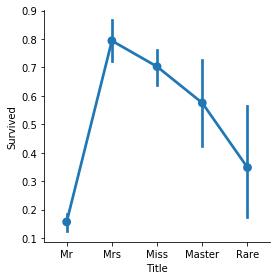

In [31]:
sns.factorplot(x="Title", y="Survived", data=train)

In [32]:
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

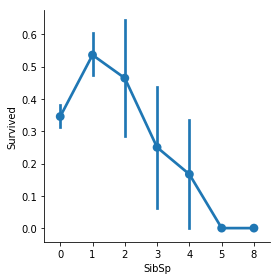

In [33]:
sns.factorplot(x="SibSp", y="Survived", data=train)

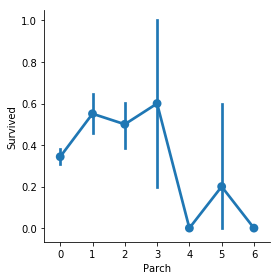

In [34]:
sns.factorplot(x="Parch", y="Survived", data=train)

In quite a few Kaggle kernels, I saw people using a variable mapping the family size of each passenger: Family size = number of children / parents + number of siblings = *Parch* + *SibSp*. 

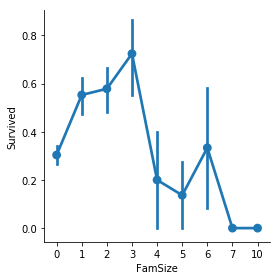

In [35]:
train['FamSize'] = train["Parch"].values+train["SibSp"]
sns.factorplot(x='FamSize', y="Survived", data=train)

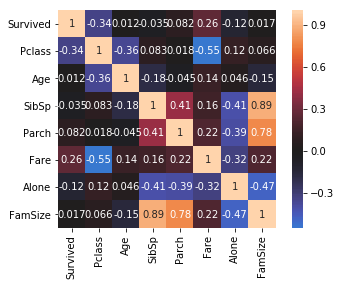

In [36]:
corr = train.corr()
sns.heatmap(corr, square=True, annot=True, center=0)

From the above plot it is not obvious to me that *FamSize* should be more correlated than *Parch* and *SibSp* separately. Probably best test it in production though.

In [37]:
test['FamSize'] = test["Parch"].values+test["SibSp"]

### Categorical variables into dummy variables
Categorical variables (*Sex*, *Title*, *Alone*, and *Embarked*) are better transformed to dummy variable (see e.g. [here](http://pbpython.com/categorical-encoding.html)). I will also transform *Pclass*, because its integer represantation doesn't map the variable well -- e.g. *Pclass* of 2 is not twice better than of 1. Dummy variable representation might work better than the integer numerical value for *Pclass*.

First, let's have look how many categories are there for each of those features and how many examples per each category.

In [38]:
pd.concat([train,test]).groupby('Sex').count()['Age']

Sex
female    466
male      843
Name: Age, dtype: int64

In [39]:
pd.concat([train,test]).groupby('Title').count()['Age']

Title
Master     61
Miss      264
Mr        757
Mrs       198
Rare       29
Name: Age, dtype: int64

In [40]:
pd.concat([train,test]).groupby('Alone').count()['Age']

Alone
0     265
1    1044
Name: Age, dtype: int64

In [41]:
pd.concat([train,test]).groupby('Embarked').count()['Age']

Embarked
C    270
Q    123
S    916
Name: Age, dtype: int64

In [42]:
pd.concat([train,test]).groupby('Pclass').count()['Age']

Pclass
1    323
2    277
3    709
Name: Age, dtype: int64

The dummy variables can be easily created with pandas. I'll keep the original features as well.

In [43]:
data = [train, test]
dummies = ['Pclass', 'Sex', 'Embarked', 'Alone', 'Title']

# keeps the original variable as well
train = pd.concat([train, pd.get_dummies(train[dummies], columns=dummies)], axis=1)
test = pd.concat([test, pd.get_dummies(test[dummies], columns=dummies)], axis=1)

# replaces the original variable by the dummy columns
#train = pd.get_dummies(train, columns=dummies)
#test = pd.get_dummies(test, columns=dummies)

In [44]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Alone', 'Title', 'FamSize', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Alone_0', 'Alone_1', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare'],
      dtype='object')

### Continuous variables binning
We are left with five continuous variables: *Age*, *Rate*, *SibSp*, *Parch*, and the newly introduced *FamSize*. 

**Age** has a substantial number of examples with a missing value. Let's have a look on some distributions. First just the distribution (histogram) of ages in the training set and how does it relate to survival.

Text(0,0.5,'#')

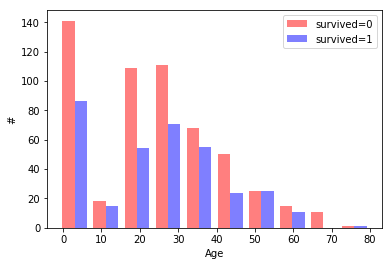

In [45]:
plt.hist([train.loc[train['Survived']==0,'Age'].values, train.loc[train['Survived']==1,'Age'].values], 
         color=['r','b'], 
         alpha=0.5,
         label=['survived=0','survived=1'])
plt.legend()
plt.xlabel('Age')
plt.ylabel('#')

We see that the fractions of survivals differ for different ages. This correlation could be more pronounced if we introduce binning in *Age*. Binning can also help to prevent overfitting (which I experienced as a major issue in my earlier modeling). Let's explore the binning choice.

Text(0,0.5,'#')

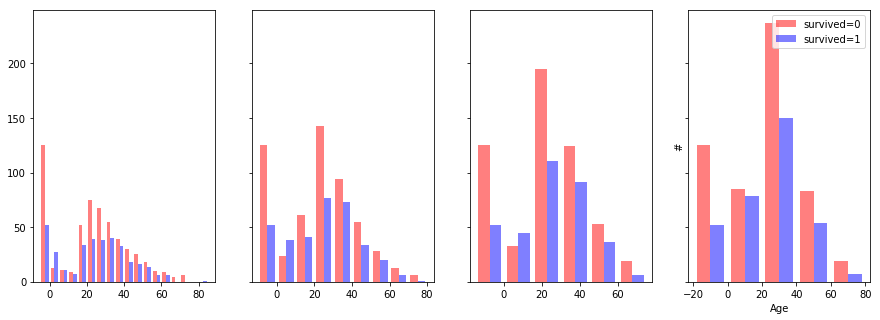

In [46]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, sharey=True, figsize=(15,5))
data_plot = [train.loc[train['Survived']==0,'Age'].values, train.loc[train['Survived']==1,'Age'].values]
hist_arg = {'color': ['r','b'], 
            'alpha': 0.5,
            'label':['survived=0','survived=1']}
for bin_size,ax in zip([5,10,15,20],[ax1,ax2,ax3,ax4]):
    ax.hist(data_plot, 
            bins=range(-bin_size,90,bin_size),
            **hist_arg)
plt.legend()
plt.xlabel('Age')
plt.ylabel('#')

([array([  10.,   19.,   23.,  176.,  149.,   37.,   10.]),
  array([  20.,   19.,   22.,   95.,  107.,   26.,    1.])],
 array([  0,   4,  12,  18,  30,  50,  65, 100]),
 <a list of 2 Lists of Patches objects>)

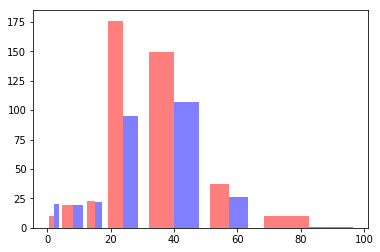

In [47]:
# this is binning used by Li-Yen Hsu in his/her kernel: Titanic - Neural Network
# in https://www.kaggle.com/liyenhsu/titanic-neural-network

plt.hist(data_plot, 
         bins=[ 0, 4, 12, 18, 30, 50, 65, 100],
         **hist_arg)

In [48]:
age_0 = train.loc[train['Survived']==0,'Age'].values
age_1 = train.loc[train['Survived']==1,'Age'].values

for bin_size in [5,10,15,20]:
    bins_0 = np.histogram(age_0,bins=range(-bin_size,90,bin_size), range=(-bin_size,80))
    bins_1 = np.histogram(age_1,bins=range(-bin_size,90,bin_size), range=(-bin_size,80))
    print(bins_1[0]/(bins_0[0]+bins_1[0]))

# and Li-Yen Hsu binning again
bins = [ 0, 4, 12, 18, 30, 50, 65, 100]
bins_0 = np.histogram(age_0,bins=bins)
bins_1 = np.histogram(age_1,bins=bins)
print(bins_1[0]/(bins_0[0]+bins_1[0]))

[ 0.29378531  0.675       0.5         0.4375      0.39534884  0.34210526
  0.35849057  0.42105263  0.45833333  0.375       0.3902439   0.4375      0.375
  0.4         0.          0.                 nan  1.        ]
[ 0.29378531  0.61290323  0.40196078  0.35        0.43712575  0.38202247
  0.41666667  0.31578947  0.14285714]
[ 0.29378531  0.57692308  0.3627451   0.42325581  0.40449438  0.24      ]
[ 0.29378531  0.48170732  0.3875969   0.39416058  0.26923077]
[ 0.66666667  0.5         0.48888889  0.35055351  0.41796875  0.41269841
  0.09090909]


/home/lucie/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


I am not sure what is the best bins choice. This is definitely something to test / work on in the future.
I will go with the last option, mostly because it is a nonlinear binning which combines smaller bins for younger ages, where the survival rate is higher, and larger bins for older passengers.


In [49]:
bins_age = [ 0, 4, 12, 18, 30, 50, 65, 100]
lab_ages = [0,1,2,3,4,5,6]

But what about the missing values of *Age*? Perhaps they could be inferred from the other data. Let's have a look on some correlations.

In [50]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Alone', 'Title', 'FamSize', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Alone_0', 'Alone_1', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare'],
      dtype='object')

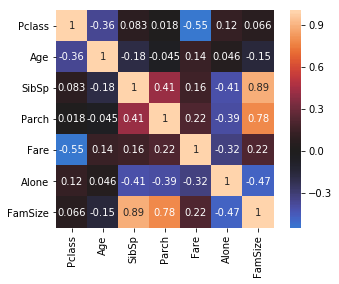

In [51]:
cols_for_age_corr = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
             'Embarked', 'Alone', 'FamSize']
corr = (train[cols_for_age_corr]).corr()
sns.heatmap(corr, square=True, annot=True, center=0)

It looks that *Age* has quite a strong correlation with *Pclass*. What about *Titles*? Let's plot age distribution for different titles and calculate the mean age and its STD.

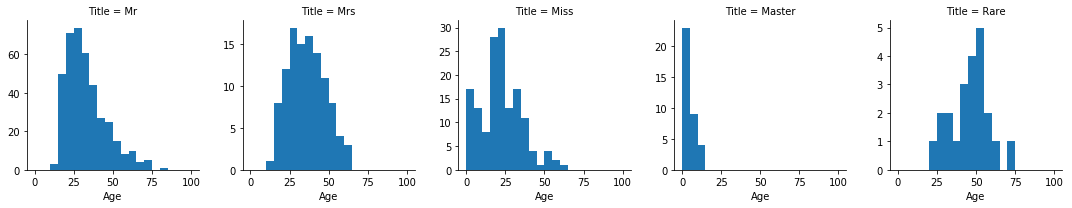

In [52]:
grid = sns.FacetGrid(train, col='Title', sharey=False)
grid.map(plt.hist, 'Age', bins=range(0,105,5))
plt.show()

In [53]:
data_all = pd.concat([train,test])
print('mean', data_all.loc[data_all['Age']>0,['Title', 'Age']].groupby(['Title']).mean())
print('std', data_all.loc[data_all['Age']>0,['Title', 'Age']].groupby(['Title']).std())

mean               Age
Title            
Master   5.482642
Miss    21.824366
Mr      32.252151
Mrs     36.918129
Rare    45.178571
std               Age
Title            
Master   4.161554
Miss    12.171431
Mr      12.422089
Mrs     12.902087
Rare    11.105733


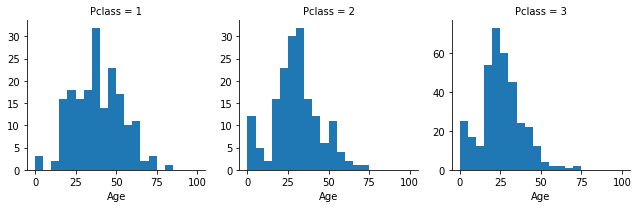

In [54]:
grid = sns.FacetGrid(train, col='Pclass', sharey=False)
grid.map(plt.hist, 'Age', bins=range(0,105,5))
plt.show()

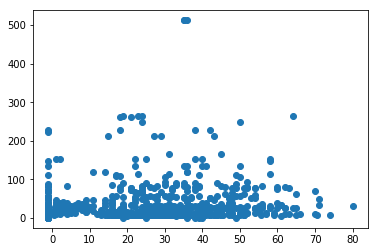

In [55]:
plt.scatter(train['Age'].values, train['Fare'])

In [56]:
# counts of missing age values for different titles
train.loc[train['Age']<0].groupby('Title').count()['Sex']

Title
Master      4
Miss       36
Mr        119
Mrs        17
Rare        1
Name: Sex, dtype: int64

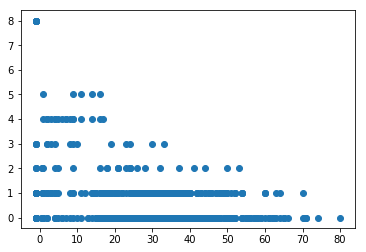

In [57]:
plt.scatter(train['Age'].values, train['SibSp'])

Hmmm, it looks like that there are some correlations. The strongest one is with *Title* and that's what I'll use. I will simply fill the missing age with a random value with Gaussian distribution of the mean and STD of given *Title*. Future work here could be invested in more sophisticated estimate of missing ages (e.g. through some ML models, see https://www.kaggle.com/liyenhsu/titanic-neural-network).

In [58]:
means = data_all.loc[data_all['Age']>0,['Title', 'Age']].groupby(['Title']).mean()
stds = data_all.loc[data_all['Age']>0,['Title', 'Age']].groupby(['Title']).std()

np.random.seed(seed=666)
data = [train,test]
for data_i in data:
    ages_i = []
    for index, row in data_i[data_i['Age']<0].iterrows():
        mu = means.loc[means.index==row['Title'],'Age'].values
        std = stds.loc[stds.index==row['Title'],'Age'].values
        ages_i.append(np.random.normal(mu,std)[0])
    #print(ages_i)
    data_i.loc[data_i['Age']<0,'Age'] = ages_i

Now when the missing values for *Age* are filled, we can bin them.

In [59]:
for data_i in data:
    data_i['Age_bin'] = pd.cut(data_i.Age,bins_age,labels=lab_ages)
train = pd.concat([train, pd.get_dummies(train['Age_bin'], columns=['Age_bin'], prefix='Age_bin', prefix_sep='_')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Age_bin'], columns=['Age_bin'], prefix='Age_bin', prefix_sep='_')], axis=1)

Lastly, I want to come back and have a brief look on **Fare** data. The original (and current, since I haven't changed anything about *Fare* yet) correlation with Survived is 0.25. However during reading through various Kaggle discussions, I came across the information that *Fare* was actually charged for the whole group of passengers on the same ticket. Let's try recalculating *Fare* and see if the correlation is stronger.

In [65]:
n_on_ticket = []
for index, row in train_raw.iterrows():
    n_on_ticket.append(1.*sum(train_raw["Ticket"]==row['Ticket']))
fare_per_person = train_raw['Fare'].values/np.array(n_on_ticket)
train_raw['Fare_pp'] = fare_per_person

In [66]:
print(train_raw.corr())

             PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   
Fare_pp        -0.002230  0.254824 -0.655559  0.227631 -0.012298  0.060240   

                 Fare   Fare_pp  
PassengerId  0.012658 -0.002230  
Survived     0.257307  0.254824  
Pclass      -0.549500 -0.655559  
Age          0.096067  0.227631  
SibSp        0.159651 -0.012298  
Parch        0.216225  0.060240  
Fare         1.000000  0.839037  
Fare_pp      0.839037  1.

The correlation of *Fare_pp* (fare per person) and Survived is basically the same. The correlation of *Fare_pp* and *Pclass* and *Age* increased wrt to those with *Fare*; while with *SibSp* and *Parch* decreased. That make sense, because the number of people on a ticket should be related to *SibSp* and *Parch* and hence this dependency was removed by normalizing *Fare* by the number of people on the ticket. 

I'm not sure if *Fare_pp* can help, but let's add it to our working datasets.

In [67]:
train['Fare_pp'] = train_raw['Fare_pp']

In [68]:
# and now for test set
n_on_ticket = []
for index, row in test_raw.iterrows():
    n_on_ticket.append(1.*sum(test_raw["Ticket"]==row['Ticket']))
test['Fare_pp'] = test['Fare'].values/np.array(n_on_ticket)

## ML Models

First let's select features that will be used in actual modeling.

In [69]:
# list of all features
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Alone', 'Title', 'FamSize', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Alone_0', 'Alone_1', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Age_bin', 'Age_bin_0',
       'Age_bin_1', 'Age_bin_2', 'Age_bin_3', 'Age_bin_4', 'Age_bin_5',
       'Age_bin_6', 'Fare_pp'],
      dtype='object')

In [70]:
features_to_use = ['Pclass_1', 'Pclass_2', 'Pclass_3', 
                   'Sex_female', 'Sex_male', 
                   'Embarked_C', 'Embarked_Q', 'Embarked_S', 
                   'Alone_0', 'Alone_1', 
                   'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 
                   'Age_bin_0', 'Age_bin_1', 'Age_bin_2', 'Age_bin_3', 'Age_bin_4', 'Age_bin_5', 'Age_bin_6', 
                   'Fare_pp', 'SibSp', 'Parch']

# training data
X_all = train[features_to_use]
y_all = train['Survived']

# test data
X_test = test[features_to_use]
# test ID to save result
pr_id = test_raw['PassengerId']

### Random Forest

I will start with Random Forest (RF, mostly because I already experimented with it in the past). RF has several hyper-parameters that can be tuned. I will use random search utility implemented in sklearn for this.

In [71]:
from scipy.stats import randint

# Randomized search on RF hyper parameters
# specify parameters and distributions to sample from
param_dist_rf = {"max_depth": randint(5, 30),
                 "min_samples_split": randint(2, 11),
                 "min_samples_leaf": randint(1, 6),
                 "max_leaf_nodes": randint(10, 50),
                 "criterion": ["gini", "entropy"],
                 "n_estimators": randint(100, 1000)}

# Utility function to report best scores
# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [72]:
from sklearn.model_selection import RandomizedSearchCV

# wrap-up function for hyper-parameter tuning of general ML classifier
def model_random_search(cl, param_dist, n_iter, X, y):
    random_search = RandomizedSearchCV(cl, 
                                       param_distributions=param_dist,
                                       n_iter=n_iter,
                                       random_state=666,
                                       cv=4)
                                       #verbose=2)
    random_search = random_search.fit(X, y)
    report(random_search.cv_results_, n_top=3)
    return random_search

In [73]:
from sklearn.ensemble import RandomForestClassifier

# less iterations used for shorter running time
#random_search_rf1 = model_random_search(RandomForestClassifier(n_jobs=1), param_dist_rf, 30, X_all, y_all)
random_search_rf1 = model_random_search(RandomForestClassifier(n_jobs=1), param_dist_rf, 5, X_all, y_all)

Model with rank: 1
Mean validation score: 0.819 (std: 0.020)
Parameters: {'min_samples_leaf': 3, 'max_leaf_nodes': 49, 'n_estimators': 985, 'max_depth': 19, 'min_samples_split': 7, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 0.817 (std: 0.019)
Parameters: {'min_samples_leaf': 5, 'max_leaf_nodes': 41, 'n_estimators': 675, 'max_depth': 24, 'min_samples_split': 3, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.816 (std: 0.020)
Parameters: {'min_samples_leaf': 5, 'max_leaf_nodes': 34, 'n_estimators': 724, 'max_depth': 16, 'min_samples_split': 6, 'criterion': 'gini'}



In [74]:
# some helper functions

def save_prediction(answer, file_out):
    np.savetxt(file_out, answer, header='PassengerId,Survived', delimiter=',', fmt='%i', comments='')
    
def apply_cl(cl, xtest, pr_id):
    pr_test_data = cl.predict(xtest)
    
    answer = np.array([pr_id,pr_test_data]).T
    #print(np.shape(answer))
    return answer

def recall(y_hat, y_obs):
    true_pos = y_obs*y_hat
    return np.sum(true_pos)/np.sum(y_obs)

def precission(y_hat, y_obs):
    true_pos = y_obs*y_hat
    return np.sum(true_pos)/np.sum(y_hat)
    
def train_cl_param(cla, X, y, param):
    cl = cla(**param)
    cl.fit(X,y)
    try: score = cl.oob_score_
    except: score = cl.score(X,y)
    r = recall(cl.predict(X), y)
    p = precission(cl.predict(X), y)
    f = 2.*(p*r)/(p+r)
    print('precission =', p, 'recall =', r, 'f-score =', f, 'score', score)
    return cl

def write_result(cl, file_out, X_test, pr_id):
    an = apply_cl(cl, X_test, pr_id)
    save_prediction(an, file_out)

Let's use the set of parameters that ranked highest in the random search.

In [75]:
par = {'max_leaf_nodes': 25, 
       'min_samples_split': 9, 
       'min_samples_leaf': 3, 
       'criterion': 'entropy', 
       'max_depth': 28, 
       'n_estimators': 557,
       'n_jobs':1,
       'oob_score':True}
rf = train_cl_param(RandomForestClassifier, X_all, y_all, par)
#write_result(rf, 'random_forest_3.csv', X_test, pr_id)

precission = 0.8606271777 recall = 0.722222222222 f-score = 0.785373608903 score 0.83164983165


This resulted in a submission with the public score of ~0.79. This is better than my earlier attempts using crudely cleaned data. Most importantly the RF model seems to generalize better. While my previous attempts with oob_score around 0.84 resulted in public score of about 0.77, the current model has oob_score of 0.82 and public score of ~0.79. The newly engineered features such as *Title* and more sophisticated filling of NaN values probably also helped.

Let's have a look on **feature importances** of the above RF (see e.g. [here](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/) for more details).

In [94]:
def get_importances(cl, features):
    importances = cl.feature_importances_
    std = np.std([cl.feature_importances_ for tree in cl.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    for i in range(len(features)):
        print(features_to_use[indices[i]], importances[indices[i]], std[indices[i]])
get_importances(rf, features_to_use)

Title_Mr 0.163425492708 1.08246744901e-15
Sex_female 0.149325072129 1.66533453694e-16
Sex_male 0.147055180636 1.13797860024e-15
Fare_pp 0.133385407999 5.27355936697e-16
Pclass_3 0.0778677996264 1.02695629778e-15
Pclass_1 0.0419424381981 6.93889390391e-18
SibSp 0.0387479464162 0.0
Title_Miss 0.037388890723 2.15105711021e-16
Title_Mrs 0.0361379021212 2.28983498829e-16
Parch 0.0231682958135 2.35922392733e-16
Pclass_2 0.0197818123432 1.94289029309e-16
Title_Master 0.0193851810668 1.28369537222e-16
Age_bin_0 0.018046258363 1.90819582357e-16
Embarked_S 0.0131712404284 0.0
Embarked_C 0.0119216999524 8.50014503229e-17
Age_bin_4 0.0103703600279 6.24500451352e-17
Alone_0 0.0101109525162 7.4593109467e-17
Alone_1 0.00936566560638 5.20417042793e-18
Title_Rare 0.00788106156365 3.64291929955e-17
Age_bin_3 0.00772042877883 3.46944695195e-18
Age_bin_5 0.00759606091375 1.90819582357e-17
Embarked_Q 0.00700139674815 4.68375338514e-17
Age_bin_1 0.00537080653922 1.30104260698e-17
Age_bin_2 0.00338641045643 

It looks like some features are not as importand as others (as expected). Particularly *Age_bin_* and *Alone_* (this might be due to its possible correlation with *Parch* and *SibSp*?). Let's try a different *Age* binning and get rid of *Alone*.

In [85]:
# ased on some discussions on Kaggle, I'll try two age bins ~ young and others
bins_age_2 = [ 0, 15, 100]
lab_ages_2 = [20,21]

for data_i in data:
    data_i['Age_bin_2'] = pd.cut(data_i.Age,bins_age_2,labels=lab_ages_2)
train = pd.concat([train, pd.get_dummies(train['Age_bin_2'], columns=['Age_bin_2'], prefix='Age_bin_2', prefix_sep='_')], axis=1)
test = pd.concat([test, pd.get_dummies(test['Age_bin_2'], columns=['Age_bin_2'], prefix='Age_bin_2', prefix_sep='_')], axis=1)

In [87]:
features_to_use_2 = ['Pclass_1', 'Pclass_2', 'Pclass_3', 
                   'Sex_female', 'Sex_male', 
                   'Embarked_C', 'Embarked_Q', 'Embarked_S',
                   'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare',
                   'Age_bin_2_0', 'Age_bin_2_1',
                   'Fare_pp', 'SibSp', 'Parch']

In [90]:
from sklearn.ensemble import RandomForestClassifier

random_search_rf2 = model_random_search(RandomForestClassifier(n_jobs=1), param_dist_rf, 100, train[features_to_use_2], y_all)

Model with rank: 1
Mean validation score: 0.822 (std: 0.023)
Parameters: {'max_depth': 12, 'criterion': 'gini', 'min_samples_leaf': 4, 'max_leaf_nodes': 17, 'min_samples_split': 2, 'n_estimators': 472}

Model with rank: 1
Mean validation score: 0.822 (std: 0.023)
Parameters: {'max_depth': 22, 'criterion': 'gini', 'min_samples_leaf': 3, 'max_leaf_nodes': 24, 'min_samples_split': 9, 'n_estimators': 109}

Model with rank: 3
Mean validation score: 0.820 (std: 0.022)
Parameters: {'max_depth': 21, 'criterion': 'entropy', 'min_samples_leaf': 2, 'max_leaf_nodes': 29, 'min_samples_split': 5, 'n_estimators': 177}

Model with rank: 3
Mean validation score: 0.820 (std: 0.025)
Parameters: {'max_depth': 11, 'criterion': 'entropy', 'min_samples_leaf': 4, 'max_leaf_nodes': 40, 'min_samples_split': 10, 'n_estimators': 684}

Model with rank: 3
Mean validation score: 0.820 (std: 0.024)
Parameters: {'max_depth': 29, 'criterion': 'entropy', 'min_samples_leaf': 5, 'max_leaf_nodes': 30, 'min_samples_split': 

In [88]:
par =  {'max_depth': 12, 'criterion': 'gini', 'min_samples_leaf': 4, 'max_leaf_nodes': 17, 'min_samples_split': 2, 'n_estimators': 472,
       'n_jobs':1,
       'oob_score':True}
rf2 = train_cl_param(RandomForestClassifier, train[features_to_use_2], y_all, par)
#write_result(rf, 'random_forest_5.csv', test[features_to_use_2], pr_id)

precission = 0.856643356643 recall = 0.716374269006 f-score = 0.78025477707 score 0.820426487093


This actually results in even better public score of ~0.8.

In [95]:
get_importances(rf2, features_to_use_2)

Title_Master 0.195148950165 7.21644966006e-16
Sex_female 0.178444194707 1.60982338571e-15
Sex_male 0.164837020421 1.36002320517e-15
Age_bin_0 0.123930056469 7.35522753814e-16
Pclass_3 0.0659386754882 4.16333634234e-16
Alone_1 0.0468510633106 9.71445146547e-17
Age_bin_1 0.0410439074151 2.56739074445e-16
Title_Miss 0.0404463292277 2.15105711021e-16
Pclass_1 0.0388173591602 2.56739074445e-16
Age_bin_2 0.0232919707869 1.45716771982e-16
Alone_0 0.0220200475818 4.85722573274e-17
Pclass_2 0.0163501681454 1.63064006742e-16
Embarked_S 0.0137423969337 4.16333634234e-17
Embarked_C 0.00958250702379 7.4593109467e-17
Title_Mr 0.00881931891298 1.11022302463e-16
Embarked_Q 0.00680136051344 3.29597460436e-17
Title_Rare 0.00201133081006 1.73472347598e-17
Title_Mrs 0.00192334292784 1.27935856353e-17


### Neural network

In [ ]:
# helper functions to generate distributions of hyper-parameters for NN

# learning rate of 0.0001--1, list of n_max floats 10**random_uniform
def rand_learning_rate(n_max=1000):
    return list(10.**np.random.uniform(-3,0,n_max))

# hidden layers: generates list of n_max tuples with 
# n_l_min--n_l_max integers, each between n_a_min and n_a_max
def rand_hidden_layer_sizes(n_l_min,n_l_max,n_a_min,n_a_max,n_max=1000):
    n_l = np.random.randint(n_l_min,n_l_max,n_max)
    list_hl = []
    for nl_i in n_l:
        list_hl.append(tuple(np.random.randint(n_a_min,n_a_max,nl_i)))
    return list_hl

In [ ]:
# NN hyper parameters to test
param_dist_nn = {"activation": ["tanh", "relu"],
                 "learning_rate_init": rand_learning_rate(),
                 "hidden_layer_sizes": rand_hidden_layer_sizes(2,15,5,20),
                 "alpha": [0.00001,0.000006,0.000003,0.000001]
                }

In [ ]:
from sklearn.neural_network import MLPClassifier

random_search_nn1 = model_random_search(MLPClassifier(batch_size=256), param_dist_nn, 50, X_all, y_all)

In [ ]:
par = {'learning_rate_init': 0.020871090748067426, 
       'alpha': 1e-06, 
       'activation': 'tanh', 
       'hidden_layer_sizes': (5, 9, 15, 10),
       'batch_size':256
       }
nn = train_cl_param(MLPClassifier, X_all, y_all, par)
write_result(nn, 'nn_1.csv', X_test, pr_id)

The public score of the above submission is 0.76, which is not better than the results of RF. It seems that NN (with the above parameters / parameters distributions) does not generalize as well as RF.

### Conclusions

I will stop here because I'm quite happy with the public score of ~0.8. Possible improvements:
- **Cabin**: Use this feature somehow instead of just dropping it. 
- **Ticket**: Infer more from ticket numbers (not just *Alone* feature based on duplicity of *Ticket* values).
- missing values of **Age**: More sophisticated estimate of the missing values (e.g. a decision tree or other ML method).
- ML **hyper-parameters** could probably be tuned some more.
- Experiment with **different binning**, mostly for *Age* and *Fare* (*Fare_pp*).
- Detailed exploration of **feature importances** which might help prevent overfitting.
- Try **different ML methods**.